# PDK

gdsfactory includes a generic Process Design Kit (PDK), that you can use as an inspiration to create your own.

A process design kit (PDK) includes:

1. LayerStack: different layers with different thickness, z-position, materials and colors.
2. Design rule checking deck DRC: Manufacturing rules capturing min feature size, min spacing ... for the process.
3. A library of Fixed or Parametric cells.

The PDK allows you to register:

- `cell` parametric cells that return Components from a ComponentSpec (string, Component, ComponentFactory or dict). Also known as parametric cell functions.
- `cross_section` functions that return CrossSection from a CrossSection Spec (string, CrossSection, CrossSectionFactory or dict).
- `layers` that return a GDS Layer (gdslayer, gdspurpose) from a string, an int or a Tuple[int, int].


Thanks to activating a PDK you can access components, cross_sections or layers using a string, a function or a dict.

Depending on the active pdk:

- `get_layer` returns a Layer from the registered layers.
- `get_component` returns a Component from the registered cells.
- `get_cross_section` returns a CrossSection from the registered cross_sections.

## layers

GDS layers are a tuple of two integer number `gdslayer/gdspurpose`

You can define all the layers from your PDK:

1. From a Klayout `lyp` (layer properties file).
2. From scratch, adding all your layers into a class.


Lets generate the layers definition code from a KLayout `lyp` file.

In [1]:
import pathlib
from functools import partial

import gdsfactory as gf
from gdsfactory.difftest import difftest
from gdsfactory.technology import (
    LayerMap,
)
from gdsfactory.typings import Layer
import gdsfactory as gf

nm = 1e-3

In [ ]:
import pytest
from pytest_regressions.data_regression import DataRegressionFixture

In [2]:
class LayerMapDemo(gf.technology.layer_map.LayerMap):
    WG: Layer = (1, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)
    PORTE: Layer = (1, 11)
    LABEL_INSTANCES: Layer = (206, 0)
    LABEL_SETTINGS: Layer = (202, 0)
    LUMERICAL: Layer = (733, 0)
    M1: Layer = (41, 0)
    M2: Layer = (45, 0)
    M3: Layer = (49, 0)
    N: Layer = (20, 0)
    NP: Layer = (22, 0)
    NPP: Layer = (24, 0)
    OXIDE_ETCH: Layer = (6, 0)
    P: Layer = (21, 0)
    PDPP: Layer = (27, 0)
    PP: Layer = (23, 0)
    PPP: Layer = (25, 0)
    PinRec: Layer = (1, 10)
    PinRecM: Layer = (1, 11)
    SHALLOWETCH: Layer = (2, 6)
    SILICIDE: Layer = (39, 0)
    SIM_REGION: Layer = (100, 0)
    SITILES: Layer = (190, 0)
    SLAB150: Layer = (2, 0)
    SLAB150CLAD: Layer = (2, 9)
    SLAB90: Layer = (3, 0)
    SLAB90CLAD: Layer = (3, 1)
    SOURCE: Layer = (110, 0)
    TE: Layer = (203, 0)
    TEXT: Layer = (66, 0)
    TM: Layer = (204, 0)
    Text: Layer = (66, 0)
    VIA1: Layer = (44, 0)
    VIA2: Layer = (43, 0)
    VIAC: Layer = (40, 0)
    WGCLAD: Layer = (111, 0)
    WGN: Layer = (34, 0)
    WGclad_material: Layer = (36, 0)


LAYER = LayerMapDemo

some generic components use some

| Layer          | Purpose                                                      |
| -------------- | ------------------------------------------------------------ |
| LABEL_INSTANCE | for adding instance labels on `gf.read.from_yaml`            |
| MTOP           | for top metal routing            |


```python
class LayersConvenient(LayerMap):
    LABEL_INSTANCE: Layer = (66, 0)
```

## cross_sections

You can create a `CrossSection` from scratch or you can customize the cross_section functions in `gf.cross_section`

In [5]:
from gdsfactory.cross_section import CrossSection, cross_section, xsection


@xsection
def strip2(
    width: float = 0.5,
    layer = (2, 0),
    radius: float = 10.0,
    radius_min: float = 5,
    **kwargs,
) -> CrossSection:
    """Return Strip cross_section."""
    return cross_section(
        width=width,
        layer=layer,
        radius=radius,
        radius_min=radius_min,
        **kwargs,
    )

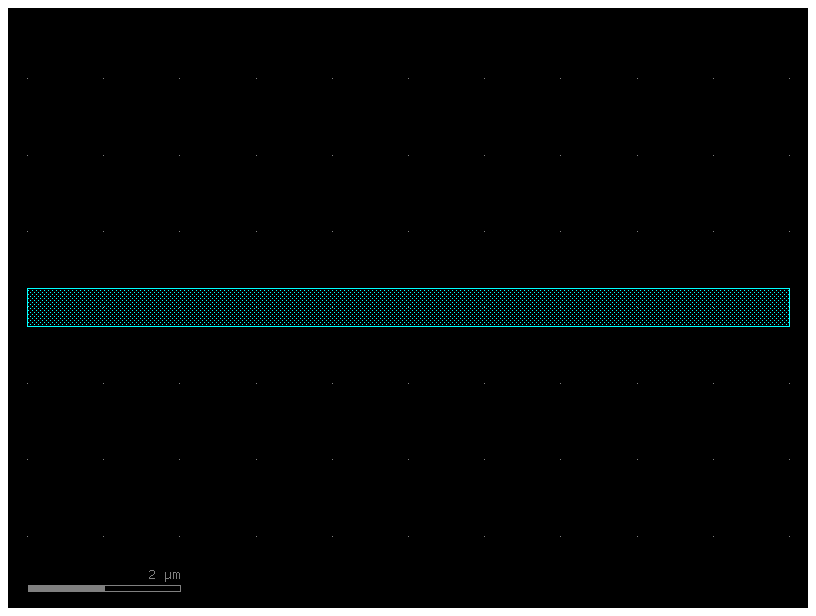

In [6]:
c = gf.components.straight(cross_section=strip2)
c.plot()

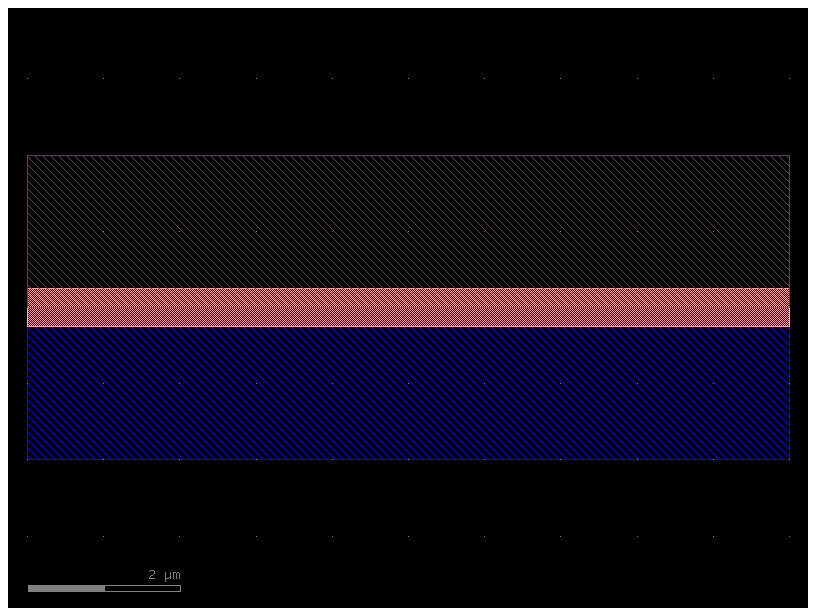

In [7]:
@xsection
def pin(
    width: float = 0.5,
    layer= "WG",
    radius: float = 10.0,
    radius_min: float = 5,
    layer_p = (21, 0),
    layer_n = (20, 0),
    width_p: float = 2,
    width_n: float = 2,
    offset_p: float = 1,
    offset_n: float = -1,
    **kwargs,
) -> CrossSection:
    """Return PIN cross_section."""
    sections = (
        gf.Section(layer=layer_p, width=width_p, offset=offset_p),
        gf.Section(layer=layer_n, width=width_n, offset=offset_n),
    )

    return cross_section(
        width=width,
        layer=layer,
        radius=radius,
        radius_min=radius_min,
        sections=sections,
        **kwargs,
    )


c = gf.components.straight(cross_section=pin)
c.plot()

In [8]:
@xsection
def strip_wide(
    width: float = 3,
    layer= (2, 0),
    radius: float = 10.0,
    radius_min: float = 5,
    **kwargs,
) -> CrossSection:
    """Return Strip cross_section."""
    return cross_section(
        width=width,
        layer=layer,
        radius=radius,
        radius_min=radius_min,
        **kwargs,
    )

In [9]:
strip = gf.cross_section.strip

In [10]:
cross_sections = dict(strip_wide=strip_wide, pin=pin, strip=strip)

## cells

Cells are functions that return Components. They are parametrized and accept also cells as parameters, so you can build many levels of complexity. Cells are also known as PCells or parametric cells.

You can customize the function default arguments easily thanks to `functools.partial`
Lets customize the default arguments of a library of cells.

For example, you can make some wide MMIs for a particular technology. Lets say the best MMI width you found it to be 9um.

In [11]:
def mmi1x2(width_mmi: float = 9, **kwargs) -> gf.Component:
    c = gf.components.mmi1x2(width_mmi=width_mmi)
    return c


def mmi2x2(width_mmi: float = 9, **kwargs) -> gf.Component:
    c = gf.components.mmi2x2(width_mmi=width_mmi)
    return c


cells = dict(mmi1x2=mmi1x2, mmi2x2=mmi2x2)

You can define a new PDK by creating function that customize partial parameters of the generic functions.

Lets say that this PDK uses layer (41, 0) for the pads (instead of the layer used in the generic pad function).

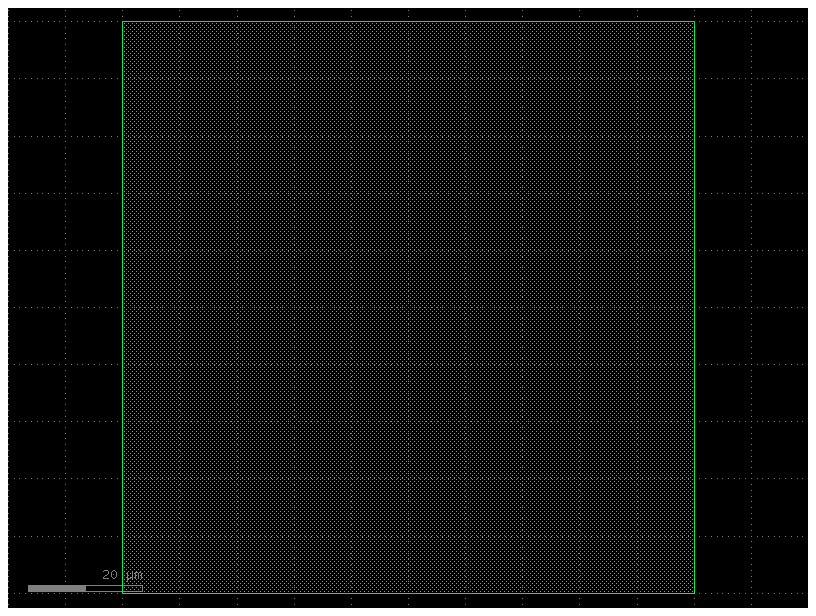

In [12]:
pad_custom_layer = partial(gf.components.pad, layer=(41, 0))
c = pad_custom_layer()
c.plot()

## PDK

You can register Layers, ComponentFactories (Parametric cells) and CrossSectionFactories (cross_sections) into a PDK.
Then you can access them by a string after you activate the pdk `PDK.activate()`.

### LayerSpec

You can access layers from the active Pdk using the layer name or a tuple/list of two numbers.

In [13]:
from gdsfactory.generic_tech import get_generic_pdk

generic_pdk = get_generic_pdk()

pdk1 = gf.Pdk(
    name="fab1",
    layers=LAYER,
    cross_sections=cross_sections,
    cells=cells,
    layer_views=generic_pdk.layer_views,
)
pdk1.activate()

In [14]:
pdk1.get_layer("WG")

<LayerMapDemo.WG: 1>

In [15]:
pdk1.get_layer([1, 0])

1

### CrossSectionSpec

You can access cross_sections from the pdk from the cross_section name, or using a dict to customize the CrossSection

In [16]:
pdk1.get_cross_section("pin")

CrossSection(sections=(Section(width=0.5, offset=0.0, insets=None, layer='WG', port_names=('o1', 'o2'), port_types=('optical', 'optical'), name='_default', hidden=False, simplify=None, width_function=None, offset_function=None), Section(width=2.0, offset=1.0, insets=None, layer=(21, 0), port_names=(None, None), port_types=('optical', 'optical'), name='s_24eda351', hidden=False, simplify=None, width_function=None, offset_function=None), Section(width=2.0, offset=-1.0, insets=None, layer=(20, 0), port_names=(None, None), port_types=('optical', 'optical'), name='s_4e8950a1', hidden=False, simplify=None, width_function=None, offset_function=None)), components_along_path=(), radius=10.0, radius_min=5.0, bbox_layers=None, bbox_offsets=None)

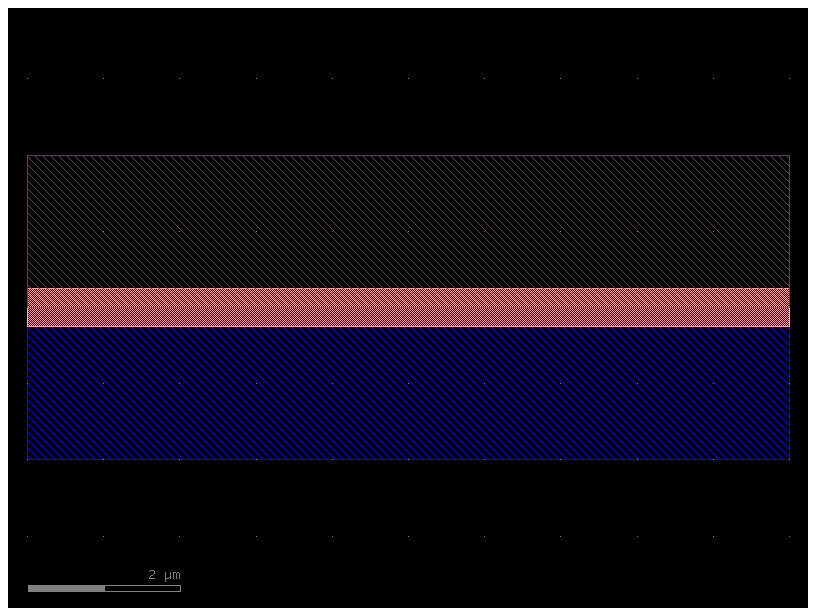

In [17]:
cross_section_spec_string = "pin"
c = gf.components.straight(cross_section=cross_section_spec_string)
c.plot()

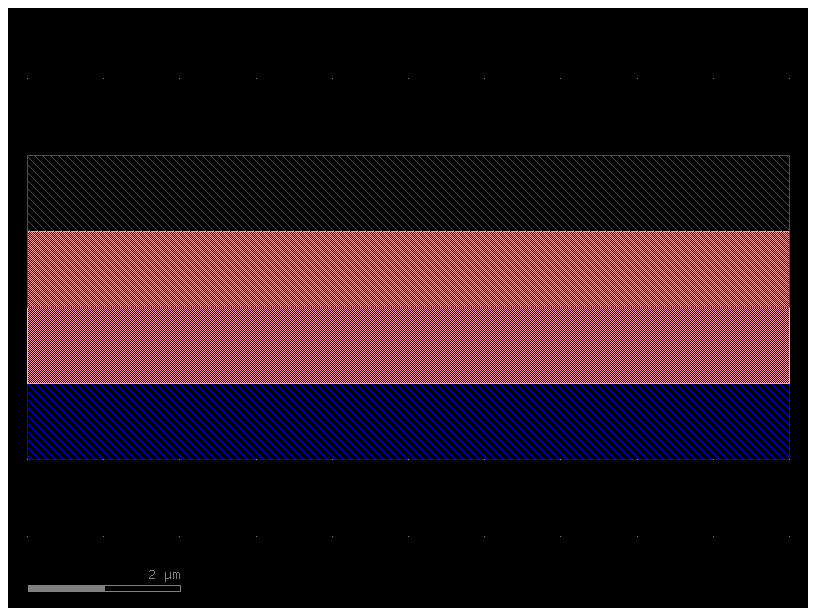

In [18]:
xs = gf.get_cross_section("pin", width=2)
wg_pin = gf.components.straight(cross_section=xs)
wg_pin.plot()

### ComponentSpec

You can get Component from the active pdk using the cell name (string) or a dict.

In [ ]:
c = pdk1.get_component("mmi1x2")
c.plot()

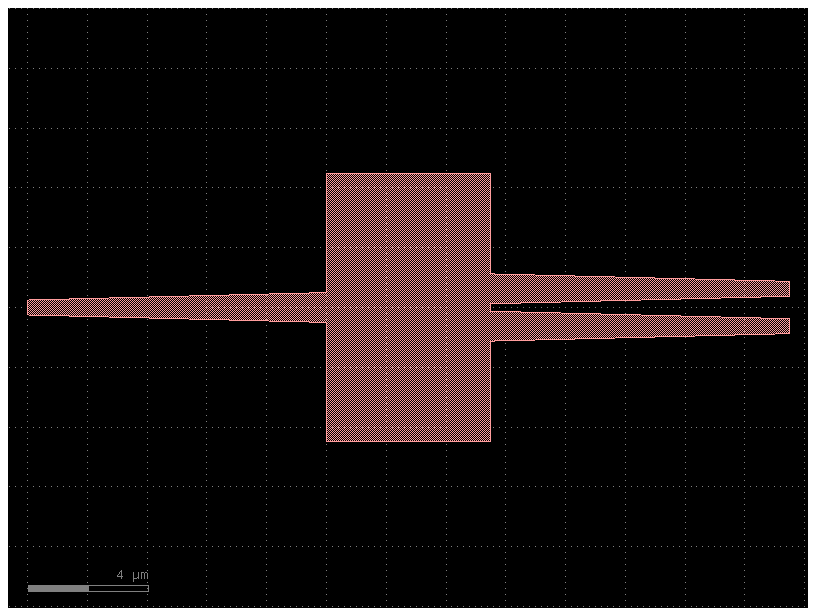

In [19]:
c = pdk1.get_component(dict(component="mmi1x2", settings=dict(length_mmi=10)))
c.plot()

## Testing PDK cells

To make sure all your PDK PCells produce the components that you want, it's important to test your PDK cells.

As you write your own cell functions you want to make sure you do not break or produced unwanted regressions later on. You should write tests for this.

Make sure you create a `test_components.py` file for pytest to test your PDK. See for example the tests in the [ubc PDK](https://github.com/gdsfactory/ubc)

Pytest-regressions automatically creates the CSV and YAML files for you, as well `gdsfactory.gdsdiff` will store the reference GDS in ref_layouts and check for geometry differences using XOR.

gdsfactory is **not** backwards compatible, which means that the package will keep improving and evolving.

1. To make your work stable you should install a specific version and [pin the version](https://martin-thoma.com/python-requirements/) in your `requirements.txt` or `pyproject.toml` as `gdsfactory==8.8.7` replacing `8.8.7` by whatever version you end up using.
2. Before you upgrade gdsfactory to a newer version make sure your tests pass to make sure that things behave as expected



In [ ]:
"""This code tests all your cells in the PDK

it will test:

1. difftest: will test the GDS geometry of a new GDS compared to a reference.
2. settings test: will compare the settings in YAML with a reference YAML.

"""

try:
    dirpath = pathlib.Path(__file__).absolute().with_suffix(".gds")
except Exception:
    dirpath = pathlib.Path.cwd()


component_names = list(pdk1.cells.keys())
factory = pdk1.cells


@pytest.fixture(params=component_names, scope="function")
def component_name(request) -> str:
    return request.param


def test_gds(component_name: str) -> None:
    """Avoid regressions in GDS files. Runs XOR and computes the area."""
    component = factory[component_name]()
    test_name = f"fabc_{component_name}"
    difftest(component, test_name=test_name, dirpath=dirpath)


def test_settings(component_name: str, data_regression: DataRegressionFixture) -> None:
    """Avoid regressions in component settings and ports."""
    component = factory[component_name]()
    data_regression.check(component.to_dict())

## Compare gds files

You can use the command line `gf gds diff gds1.gds gds2.gds` to overlay `gds1.gds` and `gds2.gds` files and show them in KLayout.

For example, if you changed the mmi1x2 and made it 5um longer by mistake, you could `gf gds diff ref_layouts/mmi1x2.gds run_layouts/mmi1x2.gds` and see the GDS differences in Klayout.

In [ ]:
help(gf.diff)

In [ ]:
mmi1 = gf.components.mmi1x2(length_mmi=5)
mmi2 = gf.components.mmi1x2(length_mmi=6)
gds1 = mmi1.write_gds()
gds2 = mmi2.write_gds()
gf.diff(gds1, gds2)